goal : predicts if pair's 1st digit <= to the second (=0) or if pair's 1st digit > to the second (=1)

Ideas of architectures to test :
- Simple MLP (fully connected)
- LetNet5
- AlexNet
- VGGNet19
- Residual Net
- Use cross entropy
- Use dropout

General framework to test :
- Network is trained to predict directly lesser or greater
- Network is trained to predict number, then we do the difference

In this notebook we explore the first architecture only

## Dataset

In [29]:
import torch
from torch import Tensor
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
import dlc_practical_prologue as prologue
from torch.optim.lr_scheduler import MultiStepLR

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Datas(Dataset):
    
    def __init__(self, train_input, train_target):
        
        self.train_input = train_input
        self.train_target = train_target

    def __len__(self):
        return len(self.train_input)

    def __getitem__(self, idx):
        return {'train': self.train_input[idx], 'target': self.train_target[idx]}

In [3]:
def hot_encode(data): # Not used in the code for classification and then comparaison
    """ 2-class hot encoding of target """
    col_view = data.view(-1,1)
    return torch.cat((col_view == 0, col_view == 1), dim=1).float()

In [4]:
N = 1000
# Load data
#train_input, train_target, _ , test_input, test_target, _ = prologue.generate_pair_sets(N)
train_input, train_target_final, train_classes, test_input, test_target_final,test_classes = prologue.generate_pair_sets(N)

In [5]:
train_binary_classes = torch.full((2*N,10), 0)
test_binary_classes = torch.full((2*N, 10), 0)
train_binary_classes.scatter_(1,train_classes.reshape((2*N, 1)), 1)
test_binary_classes.scatter_(1,test_classes.reshape((2*N, 1)), 1)
train_input, train_target = train_input.reshape((2*N, 14*14)), train_binary_classes
test_input, test_target = test_input.reshape((2*N, 14*14)), test_binary_classes

## Normalize

In [6]:
mu = train_input.mean(dim=0)
std = train_input.std(dim=0)
train_input.sub_(mu).div_(std+1)
test_input.sub_(mu).div_(std+1)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

## Models

In [43]:
class MLP(nn.Module):
    
    """ A multilayer perceptron (i.e fully connected layers only) of L hidden 
    layers of with h hidden neurons per layer """
    
    def __init__(self, L, h):
        super(MLP, self).__init__()
        # (N, 196 (=14*14)) -> (N, h)
        self.in_layer = nn.Linear(196, h)
        # (N, h) -> (N, h) -> ... -> (N, h)
        hidden_layers = []
        for l in range(L):
            hidden_layers.append(nn.ReLU())
            hidden_layers.append(nn.Linear(h,h))
        hidden_layers.append(nn.ReLU())
        self.hidden_layers = nn.Sequential(*hidden_layers)
        # (N, h) -> (N, 10)
        self.out_layer = nn.Linear(h, 10)
        
    def forward(self, x):
        # Flatten to vector before linear layers
        x = x.view(x.size(0), -1)
        # MLP net
        x = self.in_layer(x)
        x = self.hidden_layers(x)
        x = self.out_layer(x)
        return x

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        self.fc1 = nn.Linear(64, 20)
        self.fc2 = nn.Linear(20, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2))
        x = F.relu(self.fc1(x.view(-1, 64)))
        x = self.fc2(x)
        return x

    
class LeNet5Like(nn.Module):
    
    """ Modified LeNet5 (adapted to have 14*14 inputs & ouptut size 2) """
    
    def __init__(self, dropout=False):
        super(LeNet5Like, self).__init__()
        self.features = nn.Sequential(
              # (N, 1, 14, 14) -> (N, 8, 10, 10)
              nn.Conv2d(1, 8, kernel_size=3),
              nn.ReLU(),
              # (N, 8, 10, 10) -> (N, 8, 5, 5)
              nn.MaxPool2d(kernel_size=2, stride=2),
              # (N, 8, 5, 5) -> (N, 16, 1, 1)
              nn.Conv2d(8, 16, kernel_size=3),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2),
              nn.ReLU()
          )  
        if dropout :
            self.classifier = nn.Sequential(
                  # (N, 64) -> (N, 20)
                  nn.Linear(64, 20),
                  nn.ReLU(),
                  nn.Dropout(0.1),
                  # (N, 20) -> (N, 10)
                  nn.Linear(20, 10),
              )
        else :
            self.classifier = nn.Sequential(
                   # (N, 64) -> (N, 20)
                  nn.Linear(64, 20),
                  nn.ReLU(),
                  # (N, 20) -> (N, 10)
                  nn.Linear(20, 10),
              )
        
    def forward(self, x):
        # Feature block
        x = self.features(x)
        # Flatten to vector before linear layers
        x = x.view(x.size(0), -1)
        # Classifier block
        x = self.classifier(x)
        return x
    
    
class VGGNetLike(nn.Module):
    
    """ Inspired from VGGNet, adapted to have 14*14 inputs & ouptut size 2) """
    
    def __init__(self, dropout):
        super(VGGNetLike, self).__init__()
        layers = []
        # We start from 14*14 pictures padded to 16*16 and divide the 
        # dimension by two while multiplying the channel count by two 
        # at each block
        layers.append(nn.ConstantPad2d(1, 0))
        for l in range(4):
            # We go to 64 channels and multiply by 2 the number of
            # channel at each block (like in original VGGNet) 
            channels_count = 2**(6+l)
            prev_channels_count = 1 if (l == 0) else 2**(6+(l-1))
            print((prev_channels_count, channels_count))
            layers.append(nn.Conv2d(prev_channels_count, channels_count, kernel_size=3, padding=1))
            layers.append(nn.ReLU())
            #layers.append(nn.Conv2d(channels_count, channels_count, kernel_size=3, padding=1))
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))   
        self.features = nn.Sequential(*layers)
        # Classifier with fully connected layers
        if dropout :
            self.classifier = nn.Sequential(
                  # (N, 512) -> (N, 128)
                  nn.Linear(512, 128),
                  nn.ReLU(),
                  nn.Dropout(0.5),
                  # (N, 128) -> (N, 64)
                  nn.Linear(128, 64),
                  nn.ReLU(),
                  nn.Dropout(0.5),
                  # (N, 64) -> (N, 2)
                  nn.Linear(64, 10)
              )
        else :
            self.classifier = nn.Sequential(
                  # (N, 512) -> (N, 128)
                  nn.Linear(512, 128),
                  nn.ReLU(),
                  # (N, 128) -> (N, 64)
                  nn.Linear(128, 64),
                  nn.ReLU(),
                  # (N, 64) -> (N, 2)
                  nn.Linear(64, 10)
              )
        
    def forward(self, x):
        # Feature block
        x = self.features(x)
        # Flatten to vector before linear layers
        x = x.view(x.size(0), -1)
        # Classifier block
        x = self.classifier(x)
        return x

class ResBlock(nn.Module):
    def __init__(self, nb_channels, kernel_size):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(nb_channels, nb_channels, kernel_size,padding = (kernel_size-1)//2)
        self.bn1 = nn.BatchNorm2d(nb_channels)
        self.conv2 = nn.Conv2d(nb_channels, nb_channels, kernel_size,padding = (kernel_size-1)//2)
        self.bn2 = nn.BatchNorm2d(nb_channels)
    def forward(self, x):
        y = self.bn1(self.conv1(x))
        y = F.relu(y)
        y = self.bn2(self.conv2(y))
        y += x
        y = F.relu(y)
        return y
class ResNet(nn.Module):
    def __init__(self, nb_channels, kernel_size, nb_blocks):
        super(ResNet, self).__init__()
        self.conv0 = nn.Conv2d(1, nb_channels, kernel_size = 1)
        self.resblocks = nn.Sequential(
            # A bit of fancy Python
            *(ResBlock(nb_channels, kernel_size) for _ in range(nb_blocks)))
        self.avg = nn.AvgPool2d(kernel_size = 28)
        self.fc = nn.Linear(nb_channels, 10)
    def forward(self, x):
        x = F.relu(self.conv0(x))
        x = self.resblocks(x)
        x = F.relu(self.avg(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

## Train and test

In [8]:
def compute_errors(output, target):
    """ Computes error percentage given output and target"""
    errors_amount = (output.argmax(dim=1) != target.argmax(dim=1)).sum().item()
    return (errors_amount / output.shape[0]) * 100
def compute_errors2(output,target):
    errors_amount = (output.argmax(dim=1) != target).sum().item()
    return (errors_amount / output.shape[0]) * 100

In [9]:
def compute_errors_final(output,target_final):
    output_N2 = torch.argmax(output,dim=1).reshape(-1,2)
    bigger_output = torch.argmax(output_N2,dim=1)
    errors_amount = (bigger_output!=target_final).sum().item()
    return (errors_amount/output_N2.shape[0])*100

In [23]:
def train(model, train_input, train_target, test_input, test_target,test_target_final) :
    
    lr = 1e-3
    batch_size = 100
    epochs = 200
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    
    criterion = nn.MSELoss()
    
    train_errors = []
    train_errors_final = []
    test_errors = []
    test_errors_final = []
    
    for e in range(epochs):
        #print("Epoch: {}".format(e))
        print('.', end='')
        for b in range(0, train_input.size(0), batch_size):
            output = model(train_input.narrow(0, b, batch_size))
            train_target_batch = train_target.narrow(0, b, batch_size)
            loss = criterion(output, train_target_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        with torch.no_grad():
            # Compute train error
            output_train = model(train_input)
            train_errors.append(compute_errors(output_train, train_target))
            # Compute the train smaller/bigger prediction
            train_errors_final.append(compute_errors_final(output_train,train_target_final))
            # Compute test error
            output_test = model(test_input)
            test_errors.append(compute_errors(output_test, test_target))
            # Compute the test smaller/bigger prediction
            test_errors_final.append(compute_errors_final(output_test,test_target_final))
                
    return train_errors, test_errors, train_errors_final,test_errors_final

In [33]:
def train2(model, train_input, train_target, test_input, test_target,test_target_final,criteria=nn.MSELoss()) :
    
    lr = 1e-3
    batch_size = 100
    epochs = 200
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    
    criterion = criteria
    
    train_errors = []
    train_errors_final = []
    test_errors = []
    test_errors_final = []
    
    scheduler = MultiStepLR(optimizer, milestones=[10,200], gamma=0.1)
    
    for e in range(epochs):
        #scheduler.step()
        #("Epoch: {}".format(e))
        print('.', end='')
        for b in range(0, train_input.size(0), batch_size):
            output = model(train_input.narrow(0, b, batch_size))
            train_target_batch = train_target.narrow(0, b, batch_size)
            loss = criterion(output, train_target_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        with torch.no_grad():
            # Compute train error
            output_train = model(train_input)
            train_errors.append(compute_errors2(output_train, train_target))
            # Compute the train smaller/bigger prediction
            train_errors_final.append(compute_errors_final(output_train,train_target_final))
            # Compute test error
            output_test = model(test_input)
            test_errors.append(compute_errors2(output_test, test_target))
            # Compute the test smaller/bigger prediction
            test_errors_final.append(compute_errors_final(output_test,test_target_final))
                
    return train_errors, test_errors, train_errors_final,test_errors_final

In [12]:
def plot_errors(train_errors, test_errors, title,ylim = 40):
    plt.title(title)
    plt.xlabel('epoch')
    plt.ylabel('error %')
    plt.plot(train_errors, label='train error %')
    plt.plot(test_errors, label='test error %')
    plt.ylim(0, ylim)
    plt.legend()
    plt.grid()
    plt.show()

........................................................................................................................................................................................................

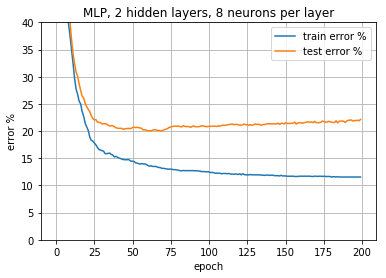

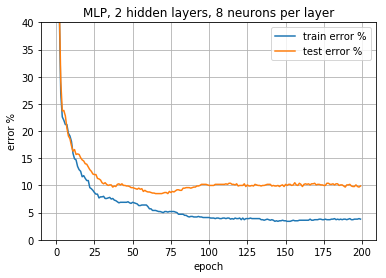

........................................................................................................................................................................................................

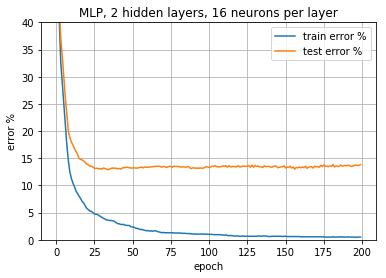

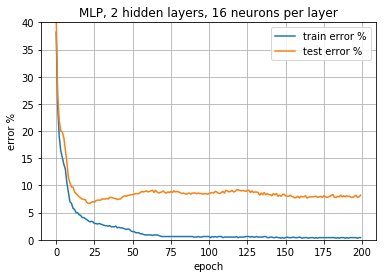

........................................................................................................................................................................................................

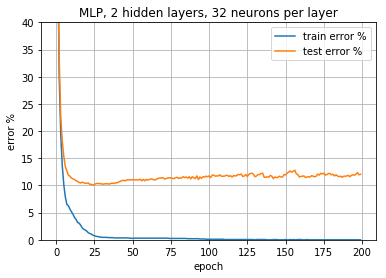

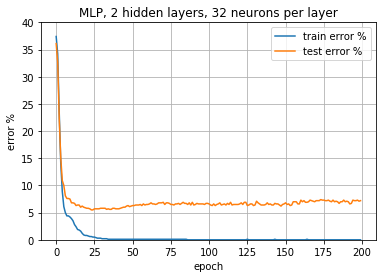

........................................................................................................................................................................................................

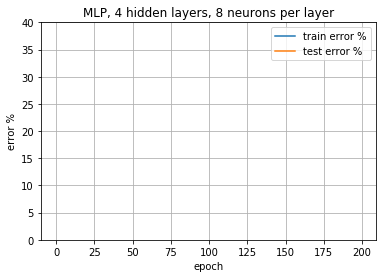

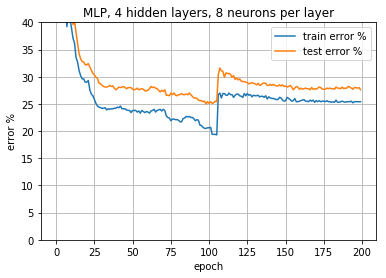

........................................................................................................................................................................................................

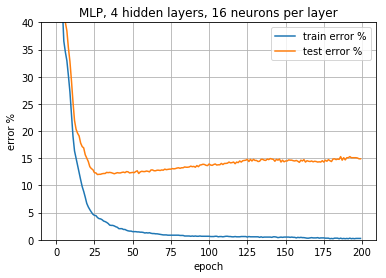

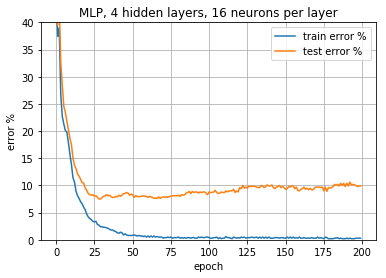

........................................................................................................................................................................................................

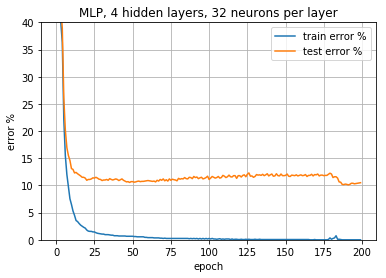

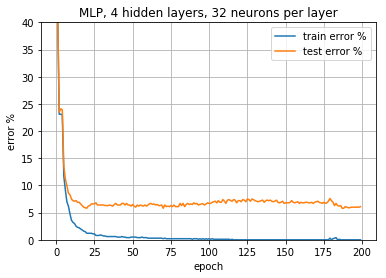

........................................................................................................................................................................................................

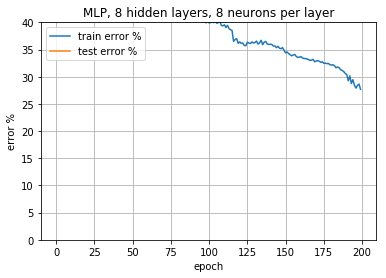

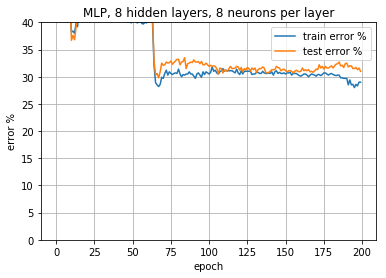

........................................................................................................................................................................................................

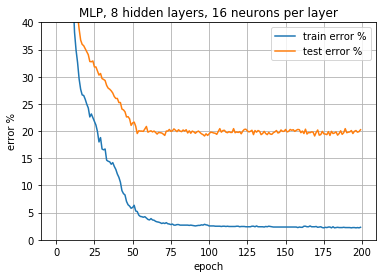

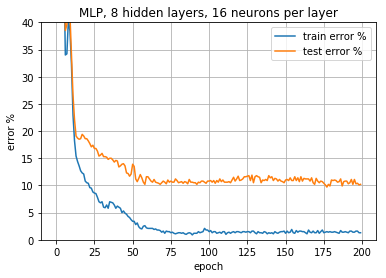

........................................................................................................................................................................................................

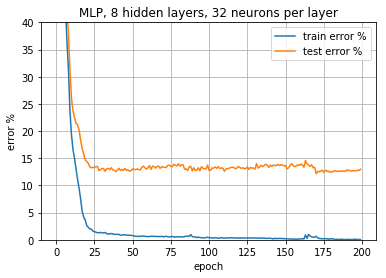

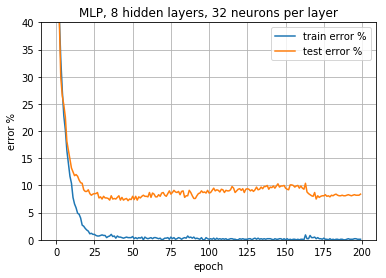

........................................................................................................................................................................................................

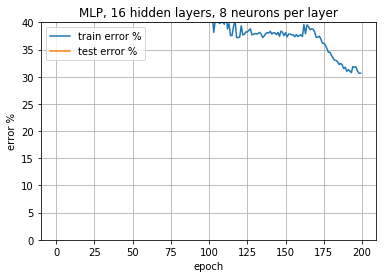

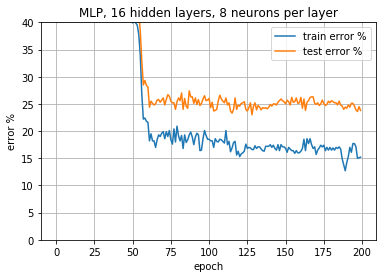

........................................................................................................................................................................................................

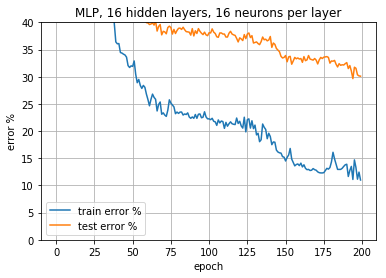

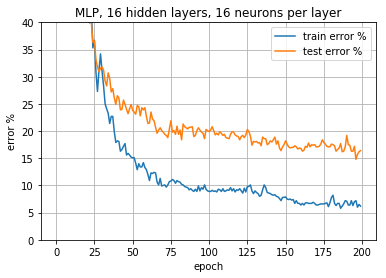

........................................................................................................................................................................................................

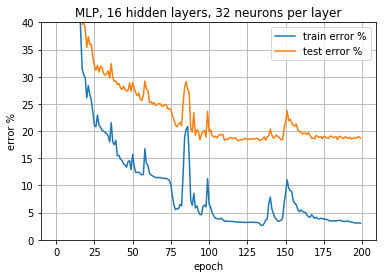

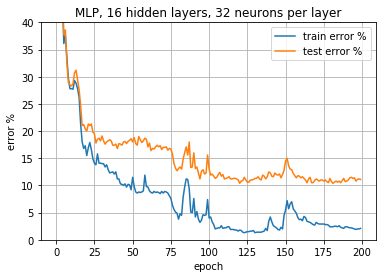

........................................................................................................................................................................................................

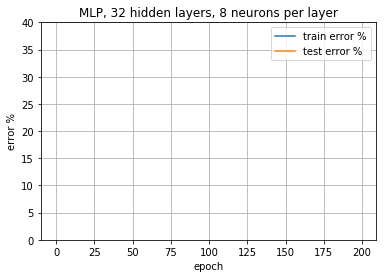

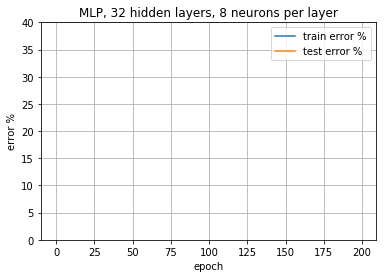

........................................................................................................................................................................................................

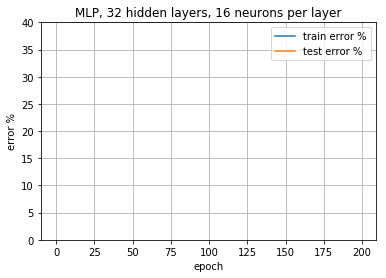

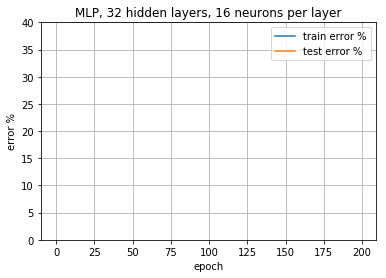

........................................................................................................................................................................................................

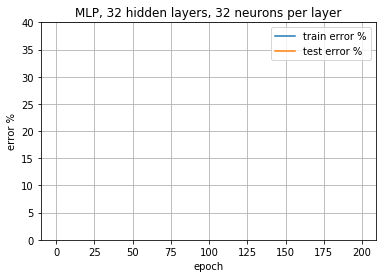

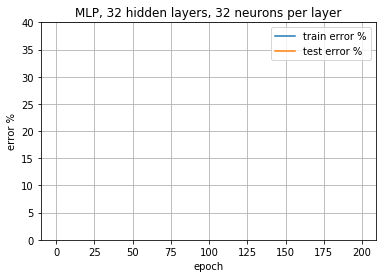

In [35]:
# MLP Models
for L in [2, 4, 8, 16, 32] :
    for h in [8, 16, 32] :
        model = MLP(L, h)
        train_errors, test_errors, train_errors_final, test_errors_final = train(model, train_input, train_target, test_input, test_target, test_target_final)
        plot_errors(train_errors, test_errors, 'MLP, {} hidden layers, {} neurons per layer'.format(L,h))
        plot_errors(train_errors_final, test_errors_final, 'MLP, {} hidden layers, {} neurons per layer'.format(L,h))
        del model

In [36]:
# Reshape the datas
train_input = train_input.reshape((2*N,1,14,14))
test_input = test_input.reshape((2*N,1,14,14))

........................................................................................................................................................................................................

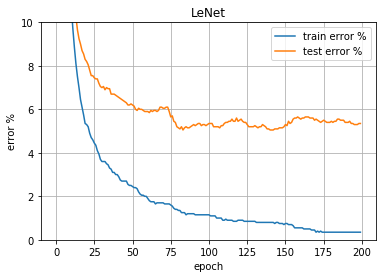

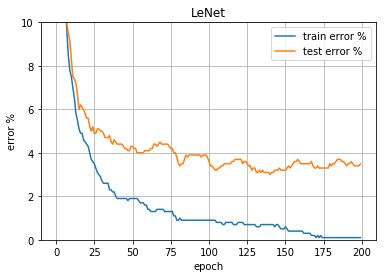

In [37]:
model = Net()
train_errors, test_errors, train_errors_final, test_errors_final = train(model, train_input, train_target, test_input, test_target,test_target_final)
plot_errors(train_errors, test_errors, 'LeNet',10)
plot_errors(train_errors_final, test_errors_final, 'LeNet',10)
del model

........................................................................................................................................................................................................

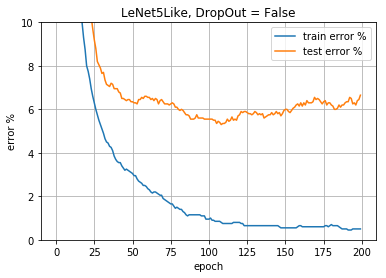

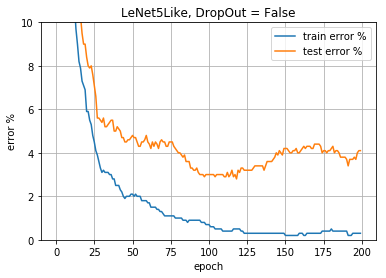

........................................................................................................................................................................................................

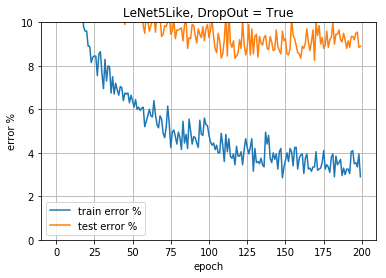

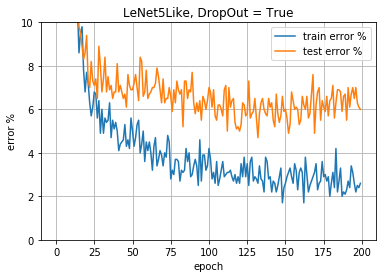

In [38]:
# LeNet5 Model
for dropout in [False, True] :
    model = LeNet5Like(dropout=dropout)
    train_errors, test_errors, train_errors_final, test_errors_final = train(model, train_input, train_target, test_input, test_target,test_target_final)
    plot_errors(train_errors, test_errors, 'LeNet5Like, DropOut = {}'.format(dropout),10)
    plot_errors(train_errors_final, test_errors_final, 'LeNet5Like, DropOut = {}'.format(dropout),10)
    del model

........................................................................................................................................................................................................

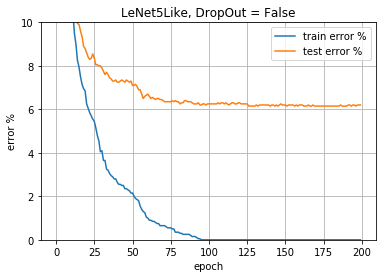

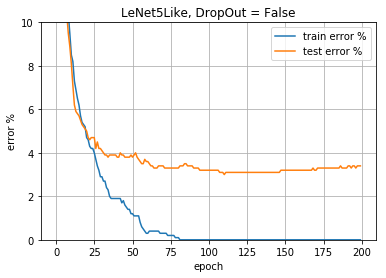

........................................................................................................................................................................................................

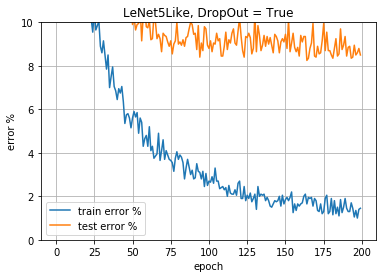

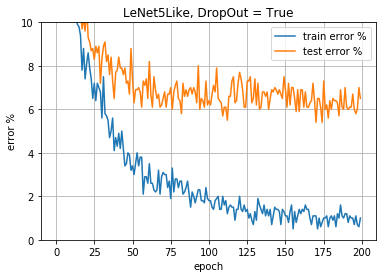

In [39]:
# LeNet5 Model with CrossEntropy
for dropout in [False, True] :
    model = LeNet5Like(dropout=dropout)
    train_errors, test_errors, train_errors_final, test_errors_final = train2(model, train_input, train_classes.reshape(2*N), test_input, test_classes.reshape(2*N),test_target_final,nn.CrossEntropyLoss())
    plot_errors(train_errors, test_errors, 'LeNet5Like, DropOut = {}'.format(dropout),10)
    plot_errors(train_errors_final, test_errors_final, 'LeNet5Like, DropOut = {}'.format(dropout),10)
    del model

(1, 64)
(64, 128)
(128, 256)
(256, 512)
........................................................................................................................................................................................................

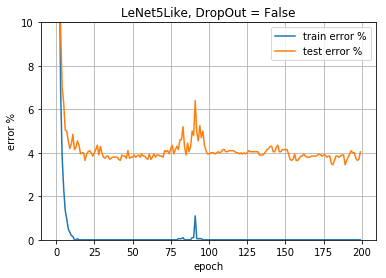

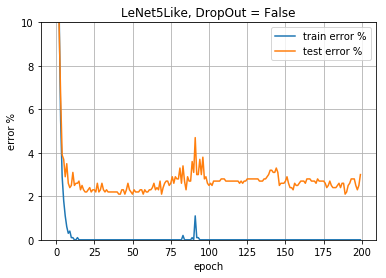

(1, 64)
(64, 128)
(128, 256)
(256, 512)
......

KeyboardInterrupt: 

In [40]:
# VGGNet Model
for dropout in [False, True] :
    model = VGGNetLike(dropout=dropout)
    train_errors, test_errors, train_errors_final, test_errors_final = train(model, train_input, train_target, test_input, test_target,test_target_final)
    plot_errors(train_errors, test_errors, 'VGGNetLike, DropOut = {}'.format(dropout),10)
    plot_errors(train_errors_final, test_errors_final, 'VGGNetLike, DropOut = {}'.format(dropout),10)
    del model

........................................................................................................................................................................................................

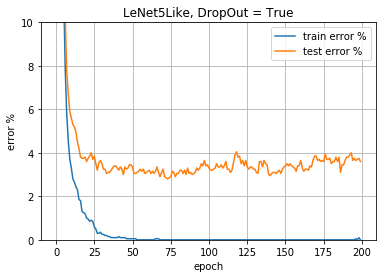

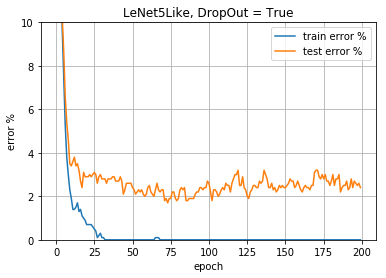

In [48]:
# ResNet
nb_channels = 16
kernel_size = 3
nb_blocks = 5
model = ResNet(nb_channels = nb_channels, kernel_size = kernel_size, nb_blocks = nb_blocks)
train_errors, test_errors, train_errors_final, test_errors_final = train(model, train_input, train_target, test_input, test_target,test_target_final)
plot_errors(train_errors, test_errors, 'LeNet5Like, DropOut = {}'.format(dropout),10)
plot_errors(train_errors_final, test_errors_final, 'LeNet5Like, DropOut = {}'.format(dropout),10)